In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

sns.set()

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [2]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [4]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [31]:
def train_and_test(model, optimizer, n_epochs, batch_size):
    # Критерий/ функция потерь
    criterion = torch.nn.BCELoss()

    epoch_array = []
    epoch_test_array = []

    for epoch in range(n_epochs):
        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()

        for i in range(0,x_train.size()[0], batch_size):
            # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            # cringe
            loss_appended = False
            
            def closure():
                optimizer.zero_grad()
                # Считаем лосс и добавляем его значение в массив
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                nonlocal loss_appended
                
                if not loss_appended:
                    loss_array.append(loss.item())
                    loss_appended = True
                    
                loss.backward()
                
                return loss

            optimizer.step(closure)


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()

        for i in range(0,x_test.size()[0], batch_size):
            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

        # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))

        display.clear_output(wait=True)

        fig = plt.figure(figsize=(12, 7))

        plt.plot(epoch_array, label="TRAIN")
        plt.plot(epoch_test_array, label="TEST")

        plt.xlabel('epoch', fontsize=16)
        plt.ylabel('loss', fontsize=16)
        plt.legend(loc="best", fontsize=20)

        plt.show()


# Adam, L-BFGS, RMSProp, SGD

## Adam

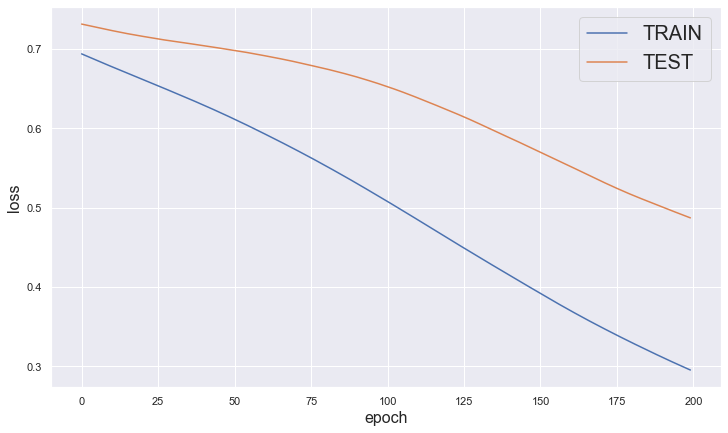

In [32]:
model = MLP(20, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=200)

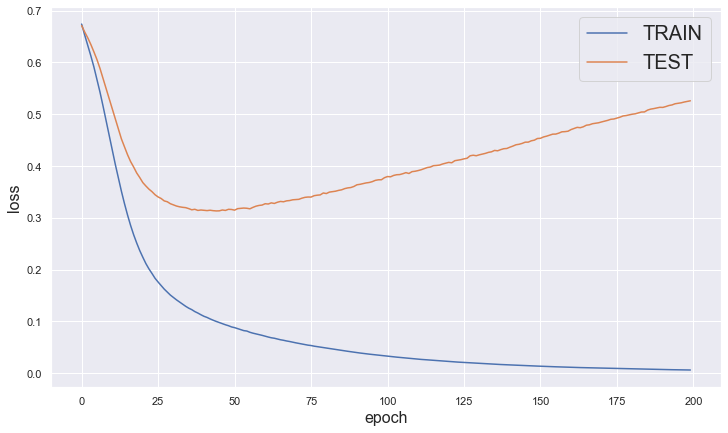

In [23]:
model = MLP(20, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=8)

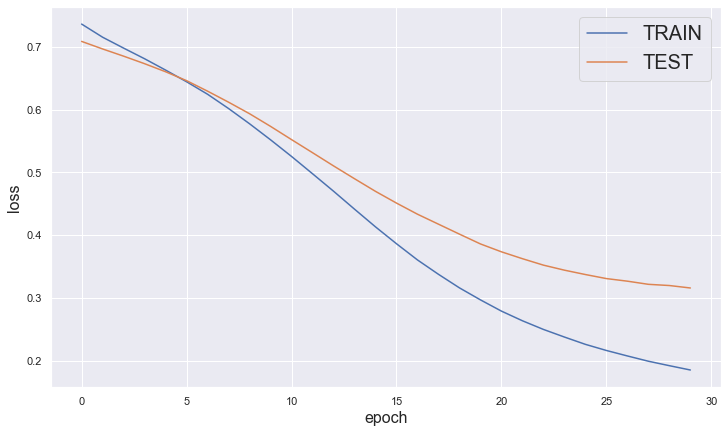

In [24]:
model = MLP(20, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=30, batch_size=8)

**Вывод:** Видим что с маленькими батчами Адам быстро переобучается. Но достигает больше точности если брать не
слишком много эпох, чем если тренить без батчей

## L-BFGS

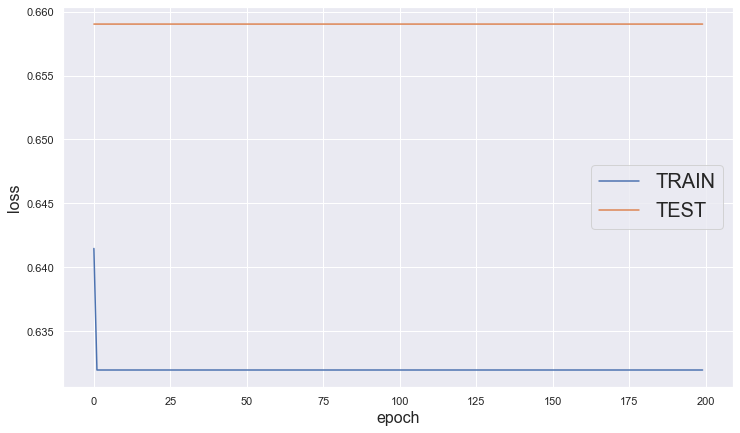

In [25]:
model = MLP(20, 10)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=8)

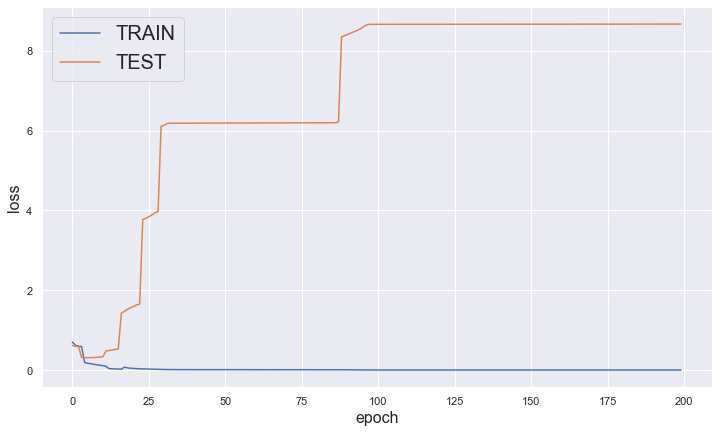

In [26]:
model = MLP(20, 10)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=200)

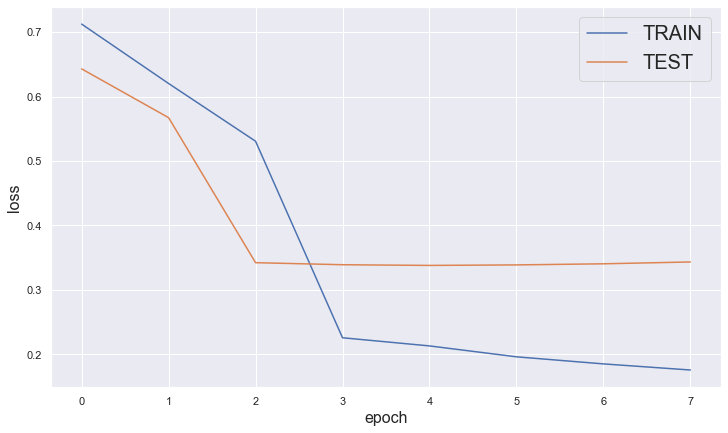

In [29]:
model = MLP(20, 10)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=8, batch_size=200)

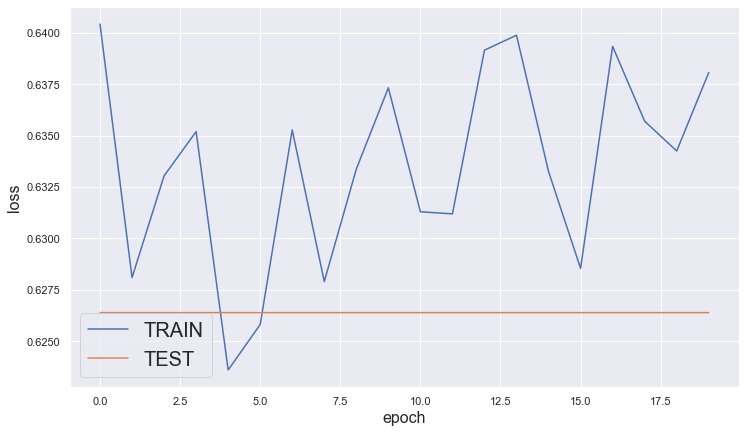

In [30]:
model = MLP(20, 10)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=20, batch_size=50)

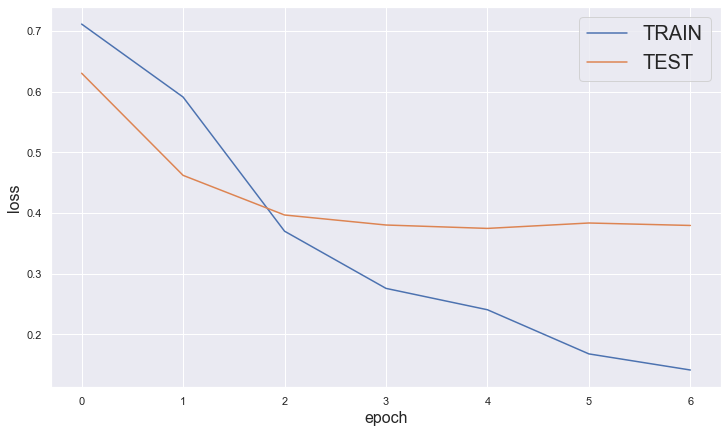

In [52]:
model = MLP(20, 10)
optimizer = optim.LBFGS(model.parameters(), lr=0.001, history_size=1)
train_and_test(model=model, optimizer=optimizer, n_epochs=7, batch_size=200)

**Вывод:** LBFGS просто ужасно работает с батчами. А без батчей очень быстро дает хорошую точность, а
дальше так же переобучается

## RMSProp

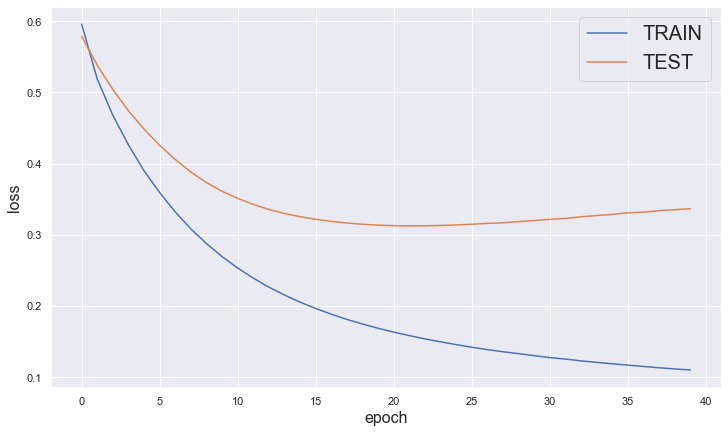

In [35]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=40, batch_size=8)

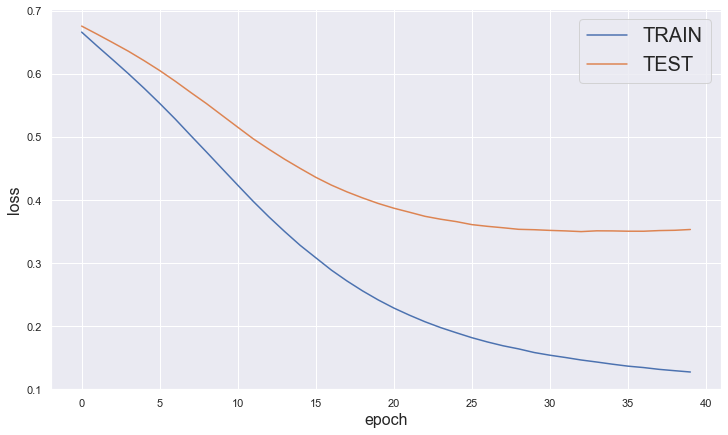

In [37]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.8)
train_and_test(model=model, optimizer=optimizer, n_epochs=40, batch_size=8)

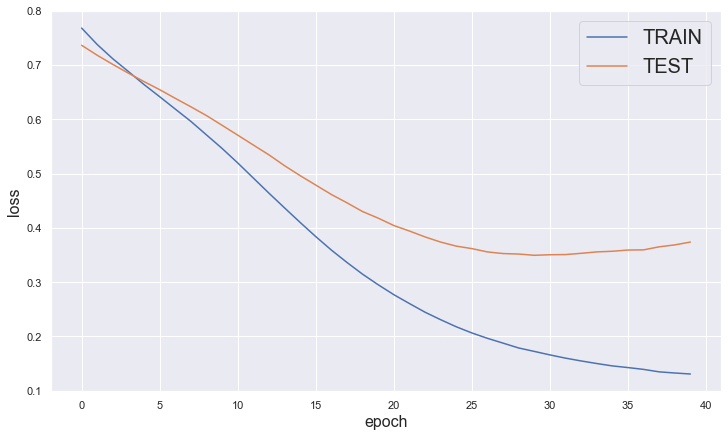

In [38]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.1)
train_and_test(model=model, optimizer=optimizer, n_epochs=40, batch_size=8)

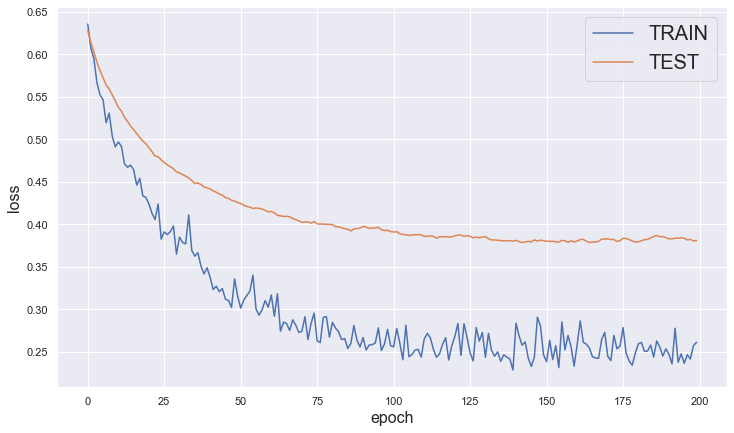

In [41]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.1)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=50)

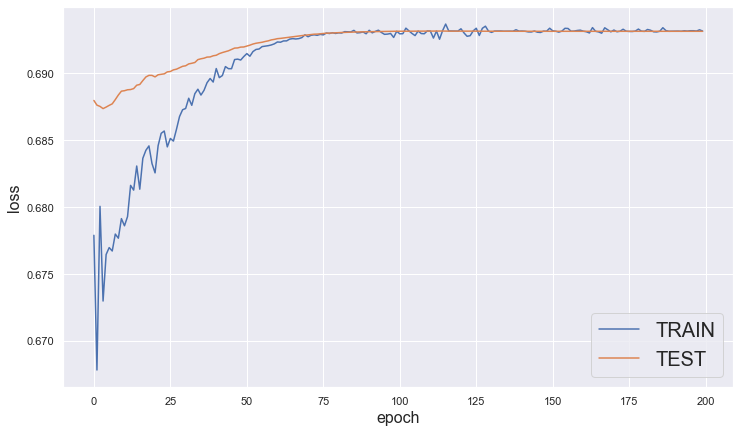

In [42]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.9)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=50)

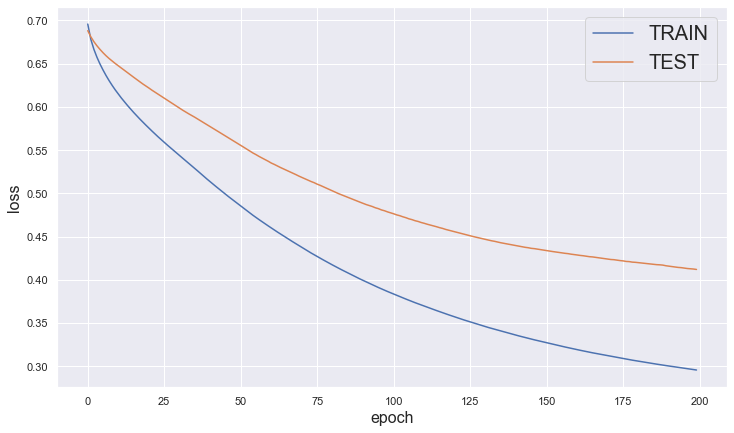

In [43]:
model = MLP(20, 10)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.1)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=200)

**Вывод:** Если брать alpha поменьше, то просто медленнее сходится. И если брать weight_decay, то появляется больше
хаоса, качество уменьшается, но зато нет переобучения. Также если взять слишком много, то модель по сути просто
будет иметь случайные веса, никакого обучения не будет

## SGD

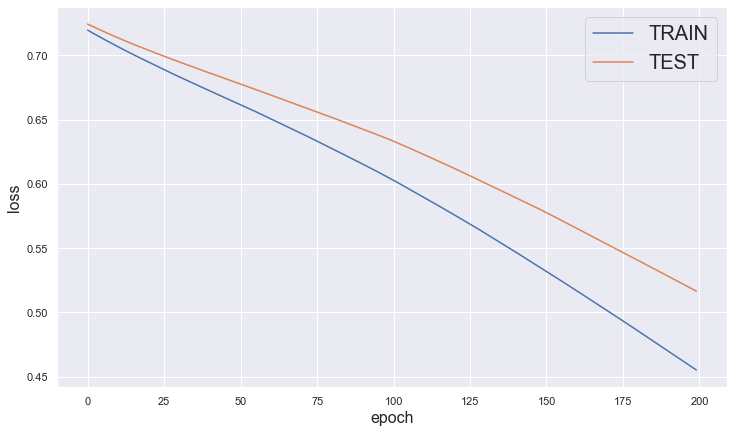

In [53]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=8)

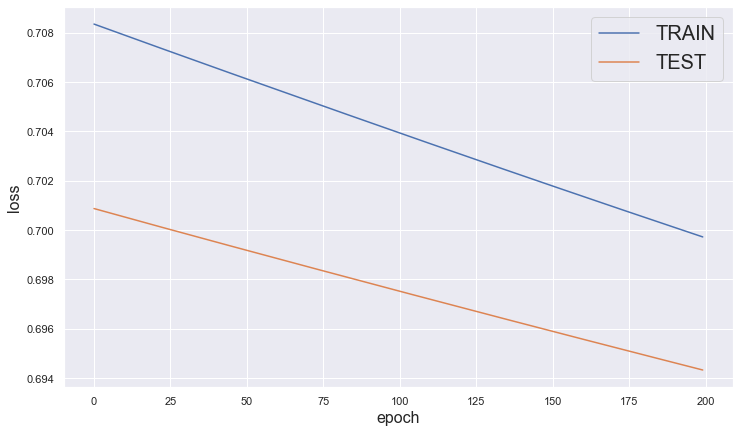

In [54]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=200)

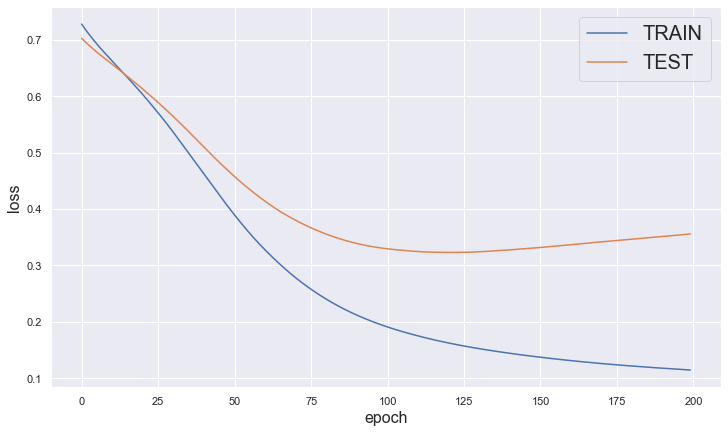

In [56]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_and_test(model=model, optimizer=optimizer, n_epochs=200, batch_size=200)

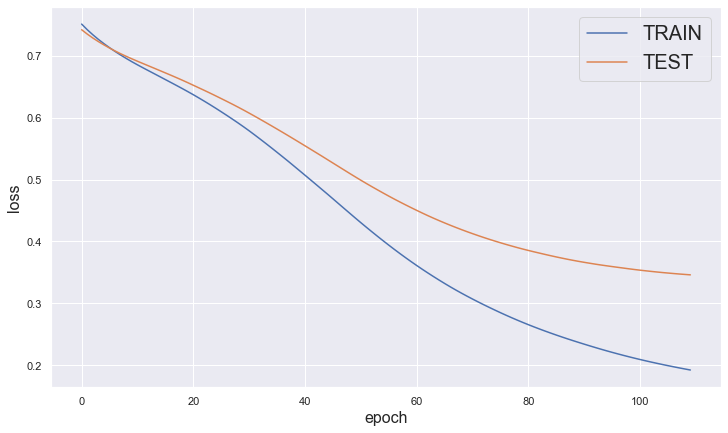

In [57]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_and_test(model=model, optimizer=optimizer, n_epochs=110, batch_size=200)

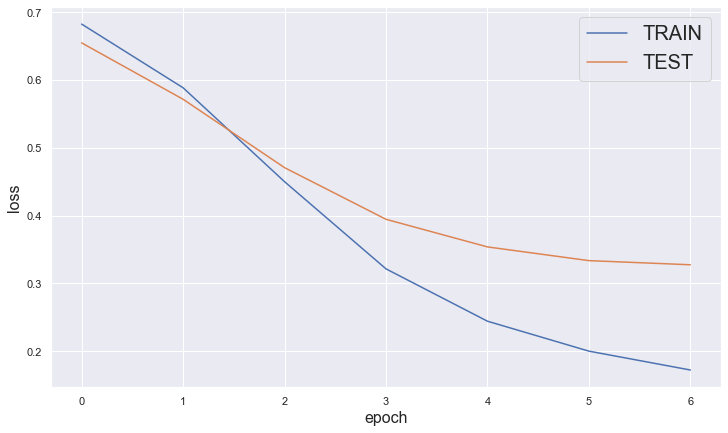

In [60]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_and_test(model=model, optimizer=optimizer, n_epochs=7, batch_size=8)

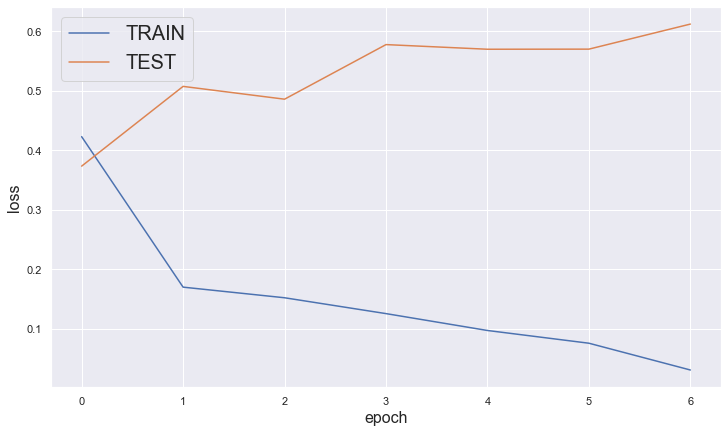

In [62]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
train_and_test(model=model, optimizer=optimizer, n_epochs=7, batch_size=8)

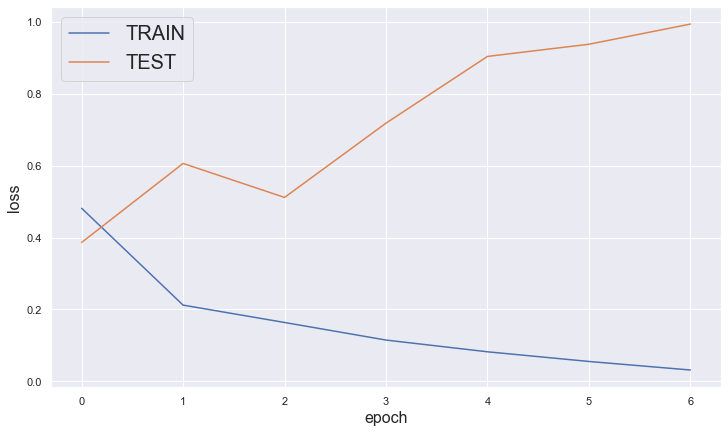

In [63]:
model = MLP(20, 10)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
train_and_test(model=model, optimizer=optimizer, n_epochs=7, batch_size=8)

**Вывод:** SGD сходится очень медленно по сравнению с другими - ему нужен lr в 100 раз больше чтобы было что-то
адекватное. А также с маленькими батчами он сходится в разы быстрее. А с моментом сходится вообще за 1 эпоху

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

**Вывод:** После какого-то момента все оптимизаторы начинают переобучаться, если только не поставить weight_decay.
Все сходятся где-то к 0.3 с чем-то на тесте, видимо лучше нельзя на таких данных и такой модели